In [49]:
import pandas as pd
import random
import numpy as np

# Load the word list from a CSV file
wordle = pd.read_csv("wordle.csv")
word_listFull = wordle['word'].tolist()
word_list = wordle.sample(n=100)["word"].tolist()

# Filter out any words that are not exactly five letters
# word_list = [word for word in word_list if len(word) == 5 and word.isalpha()]

In [ ]:
wordle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12972 entries, 0 to 12971
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   word        12972 non-null  object 
 1   occurrence  12972 non-null  float64
 2   day         2315 non-null   float64
dtypes: float64(2), object(1)
memory usage: 304.2+ KB


In [ ]:
# !pip install torch

In [30]:
class WordleEnvironment:
    def __init__(self, word_list):
        self.word_list = word_list
        self.word_to_index = {word: i for i, word in enumerate(word_list)}
        self.index_to_word = {i: word for i, word in enumerate(word_list)}
        self.target_word = None
        self.attempts_remaining = 6
        self.state = None
        self.reset()

    def encode_feedback(self, feedback):
        encoding = {'green': [1, 0, 0], 'yellow': [0, 1, 0], 'black': [0, 0, 1]}
        return [encoding[f] for f in feedback]

    def encode_state(self):
        # Flatten the state matrix into a single vector for NN input
        return np.array([item for sublist in self.state for item in sublist])

    def reset(self):
        self.target_word = random.choice(self.word_list)
        self.attempts_remaining = 6
        self.state = [[0, 0, 0] for _ in range(5*6)]  # Initialize to all 'black'
        return self.encode_state()

    def provide_feedback(self, guess):
        feedback = []
        for i, char in enumerate(guess):
            if char == self.target_word[i]:
                feedback.append('green')
            elif char in self.target_word:
                feedback.append('yellow')
            else:
                feedback.append('black')
        return feedback

    def update_state(self, guess, feedback):
        attempt_index = 6 - self.attempts_remaining
        self.state[attempt_index * 5:(attempt_index + 1) * 5] = self.encode_feedback(feedback)

    def calculate_reward(self, feedback):
        # Custom reward logic: 3 points for green, 1 point for yellow, and -1 for black
        return sum(3 if f == 'green' else 1 if f == 'yellow' else -1 for f in feedback)

    def step(self, action_index):
        guess = self.index_to_word[action_index]
        feedback = self.provide_feedback(guess)
        self.update_state(guess, feedback)
        self.attempts_remaining -= 1
        done = guess == self.target_word or self.attempts_remaining == 0
        reward = self.calculate_reward(feedback)
        return self.encode_state(), reward, done


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [26]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


In [38]:
import random
import torch
import torch.optim as optim
import torch.nn as nn

class DQNAgent:
    def __init__(self, state_size, action_size, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.0001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(10000)
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters())
        self.criterion = nn.MSELoss()
        self.batch_size = 64
        self.gamma = 0.99  # Discount factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def update_epsilon(self, episode):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay * episode)

    def update_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.model(next_states).max(1)[0]
        expected_q = rewards + self.gamma * next_q * (1 - dones)

        loss = self.criterion(current_q, expected_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_size)
        return action

    def learn(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.update_model()


In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(total_rewards, success_counts, move_counts, episodes):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(total_rewards)
        plt.title('Total Rewards Over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')

        plt.subplot(1, 3, 2)
        plt.plot(np.cumsum(success_counts) / np.arange(1, len(success_counts) + 1) * 100)
        plt.title('Cumulative Success Rate Over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate (%)')

        plt.subplot(1, 3, 3)
        plt.plot(move_counts)
        plt.title('Moves Per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Number of Moves')

        plt.tight_layout()
        plt.show()


def run_simulation(agent, environment, episodes, report_every=100):
    total_rewards = []
    success_counts = []
    move_counts = []

    for episode in range(episodes):
        state = environment.reset()
        done = False
        total_reward = 0
        moves = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = environment.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state

            total_reward += reward
            moves += 1
            if done and environment.target_word == environment.index_to_word[action]:
                success_counts.append(1)
            else:
                success_counts.append(0)

        total_rewards.append(total_reward)
        move_counts.append(moves)

        if (episode + 1) % report_every == 0:
            average_reward = np.mean(total_rewards[-report_every:])
            success_rate = np.mean(success_counts[-report_every:]) * 100
            average_moves = np.mean(move_counts[-report_every:])
            print(f"Episode {episode + 1}: Average Reward = {average_reward:.2f}, Success Rate = {success_rate:.2f}%, Average Moves = {average_moves:.2f}")

    return total_rewards, success_counts, move_counts, plot_results(total_rewards, success_counts, move_counts, episodes)


Episode 100: Average Reward = -8.70, Success Rate = 0.00%, Average Moves = 6.00
Episode 200: Average Reward = -8.28, Success Rate = 0.00%, Average Moves = 6.00
Episode 300: Average Reward = -8.84, Success Rate = 0.00%, Average Moves = 6.00
Episode 400: Average Reward = -7.82, Success Rate = 0.00%, Average Moves = 6.00
Episode 500: Average Reward = -8.00, Success Rate = 0.00%, Average Moves = 5.96
Episode 600: Average Reward = -7.62, Success Rate = 0.00%, Average Moves = 6.00
Episode 700: Average Reward = -8.32, Success Rate = 0.00%, Average Moves = 6.00
Episode 800: Average Reward = -8.46, Success Rate = 0.00%, Average Moves = 6.00
Episode 900: Average Reward = -8.96, Success Rate = 0.00%, Average Moves = 6.00
Episode 1000: Average Reward = -9.20, Success Rate = 0.00%, Average Moves = 6.00


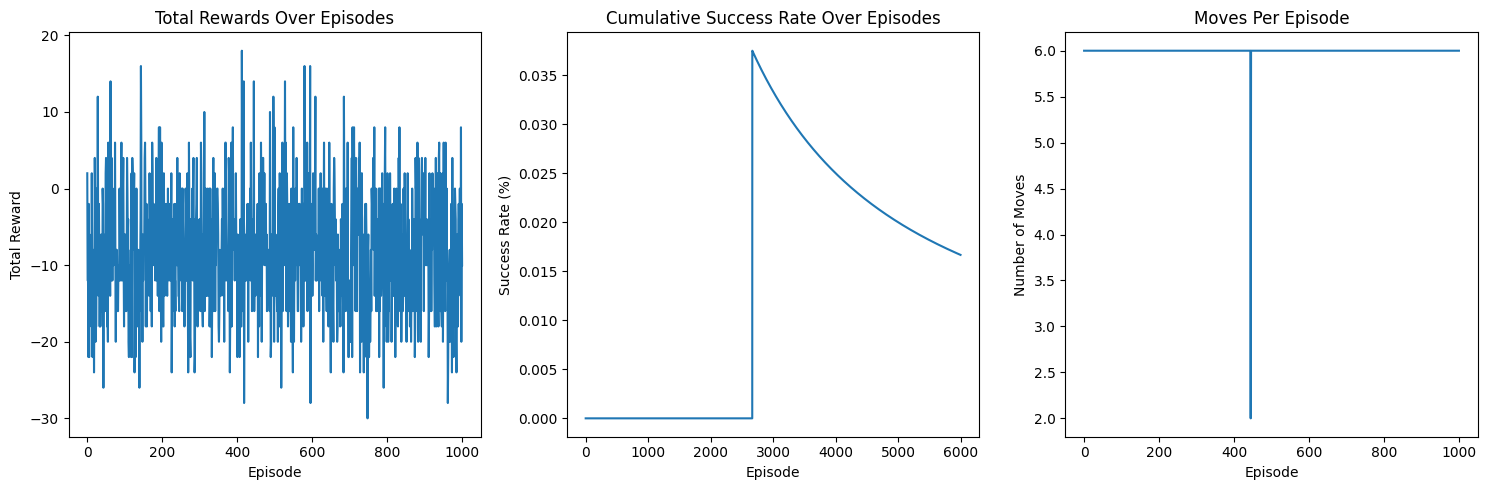

([2,
  -12,
  -12,
  -22,
  -2,
  -22,
  -6,
  -16,
  -10,
  -12,
  -12,
  -18,
  2,
  -10,
  -22,
  -10,
  -8,
  -12,
  -24,
  -14,
  4,
  -2,
  -20,
  -18,
  -18,
  0,
  -12,
  -6,
  12,
  -6,
  -14,
  -2,
  -8,
  -18,
  -10,
  -18,
  -14,
  -6,
  -8,
  -16,
  -16,
  0,
  -2,
  -26,
  -6,
  -12,
  -16,
  -14,
  -12,
  2,
  4,
  -16,
  -8,
  -18,
  -16,
  -20,
  6,
  -6,
  2,
  2,
  -6,
  -14,
  14,
  -10,
  -12,
  4,
  -4,
  -12,
  -2,
  -8,
  -10,
  -4,
  0,
  -8,
  6,
  -10,
  -20,
  -8,
  -8,
  -8,
  -12,
  -16,
  -16,
  -10,
  -12,
  -12,
  0,
  -6,
  -12,
  -8,
  2,
  6,
  -12,
  -12,
  -8,
  0,
  4,
  -10,
  -18,
  -6,
  -10,
  -6,
  -16,
  -8,
  -16,
  -12,
  4,
  0,
  -6,
  -4,
  -20,
  -22,
  -14,
  -10,
  -16,
  -14,
  -8,
  -22,
  2,
  -22,
  4,
  2,
  -6,
  -8,
  -2,
  2,
  -24,
  -16,
  -8,
  -22,
  -14,
  0,
  -16,
  -18,
  -12,
  -8,
  -8,
  -12,
  -16,
  -26,
  -14,
  -10,
  -4,
  16,
  6,
  -16,
  -10,
  -20,
  -6,
  -12,
  -8,
  -8,
  -6,
  4,
  6,
  -2,
  -18,
  -8

In [50]:
# Assume the word list is already loaded and preprocessed
# word_list = ["spire", "crane", "slate", "champ", "ghost", "flint", "grace", "laugh", "sight", "bloom"]

# Initialize environment and agent
environment = WordleEnvironment(word_listFull)

state_size = 90  # 5 letters * 6 attempts * 3 (green, yellow, black)
action_size = len(word_listFull)  # Number of possible words the agent can guess
agent = DQNAgent(state_size, action_size)
# agent = DQNAgent(len(word_list), len(word_list))  # Assuming state size and action size are both the length of the word list

# Run the simulation for a certain number of episodes
# total_rewards, success_counts, move_counts = run_simulation(agent, environment, 1000, report_every=100)
run_simulation(agent,environment,1000,report_every=100)

# Plot the results
# plot_results(total_rewards, success_counts, move_counts, 1000)


In [ ]:
# def train_dqn(episodes):
#     for episode in range(episodes):
#         state = env.reset()
#         total_reward = 0
#         done = False
#         while not done:
#             action = agent.act(state, epsilon)
#             next_state, reward, done = env.step(action)
#             agent.memory.push(state, action, reward, next_state, done)
#             state = next_state
#             total_reward += reward
#             agent.update_model()
#         print(f'Episode: {episode}, Total reward: {total_reward}')
#         epsilon = max(epsilon * decay, 0.01)
